# 1. Dataset and background

## Background

The dataset is obtained from some unnamed institute, provided by Dhanush Narayanan R via Kaggle. The dataset features transactional metadata related to fraud detection:

| Feature                       | Description                                                        |
|-------------------------------|--------------------------------------------------------------------|
| distance_from_home            | The distance from home where the transaction happened              |
| distance_from_last_transaction| The distance from last transaction happened                        |
| ratio_to_median_purchase_price| Ratio of purchased price transaction to median purchase price      |
| repeat_retailer               | Is the transaction happened from same retailer                     |
| used_chip                     | Is the transaction through chip (credit card)                      |
| used_pin_number               | Is the transaction happened by using PIN number                    |
| online_order                  | Is the transaction an online order                                 |
| fraud                         | Is the transaction fraudulent                                      |

### Questions

1. Does physical location actually matter?
	- Hypothesis: Greater distance increases fraud probability

2. Do security measures work?
	- Hypothesis: Using a PIN should show negative correlation with fraud probability

3. Is the purchase amount definitive?
	- Hypothesis: Larger spent amout increases fraud probability

### Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('datasets/card_transdata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [3]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


# 2. Correlation Analysis

### Corrrelation Matrix
In this section, we generate a correlation heatmap to identify which variables strongly associate with fraud.

Correlation with Fraud Risk:
fraud                             1.000000
ratio_to_median_purchase_price    0.462305
online_order                      0.191973
distance_from_home                0.187571
distance_from_last_transaction    0.091917
repeat_retailer                  -0.001357
used_chip                        -0.060975
used_pin_number                  -0.100293
Name: fraud, dtype: float64


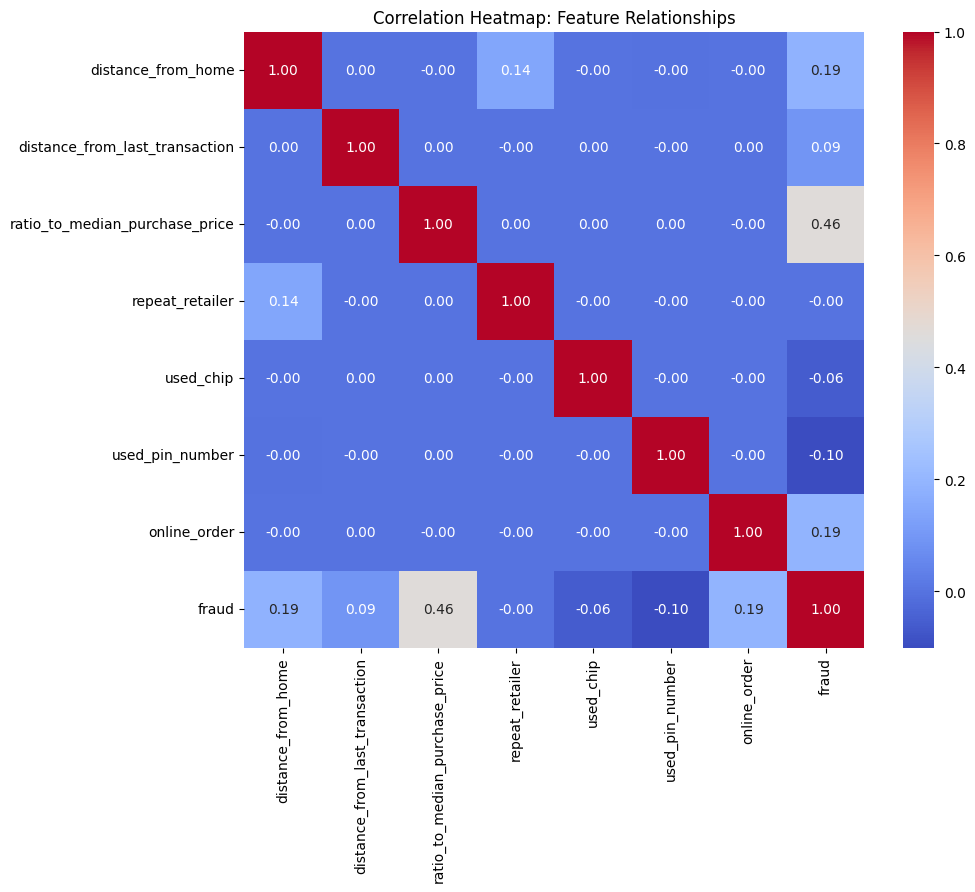

In [4]:
# Calculate correlations with the target variable 'fraud'
# Note: Mathematically, Pearson calculation on binary data yields the Point-Biserial/Phi coefficient values.
correlations = df.corr()['fraud'].sort_values(ascending=False)

print("Correlation with Fraud Risk:")
print(correlations)

# Visualization: Heatmap of the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Feature Relationships")
plt.show()

**Key Findings:**


- **Ratio to Median Purchase Price** ($r = 0.46$): This shows the strongest positive correlation. As the purchase amount exceeds the user's median history, fraud risk increases significantly.


- **Online Order** ($r = 0.19$): A moderate positive association, indicating online transactions are riskier.


- **Distance From Home** ($r = 0.19$): A moderate positive association, indicating that transactions occurring farther from the cardholder's home are riskier.


- **Used Pin Number** ($r = -0.10$): A negative correlation. This provides statistical evidence that security measures (PINs) effectively reduce fraud association.

# 3. Regression Analysis

In this section, we perform a logistic regression to quantify the impact of each feature on the probability of fraud. The model estimates the odds that a transaction is fraudulent based on all available predictors.

In [8]:
import statsmodels.api as sm
# Define Independent Variables (X) and Dependent Variable (y)
# We add a constant (intercept) as required by the regression equation Y = bX + a (Slide 13)
X = df.drop(columns=['fraud'])
X = sm.add_constant(X) 
y = df['fraud']

# Fit Logistic Regression Model
model = sm.Logit(y, X).fit()

# Print Summary (Matches the format of the SPSS printout in Slide 17)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.135695
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              1000000
Model:                          Logit   Df Residuals:                   999992
Method:                           MLE   Df Model:                            7
Date:                Wed, 24 Dec 2025   Pseudo R-squ.:                  0.5423
Time:                        18:58:00   Log-Likelihood:            -1.3570e+05
converged:                       True   LL-Null:                   -2.9649e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.3611      0.044   -237.200    

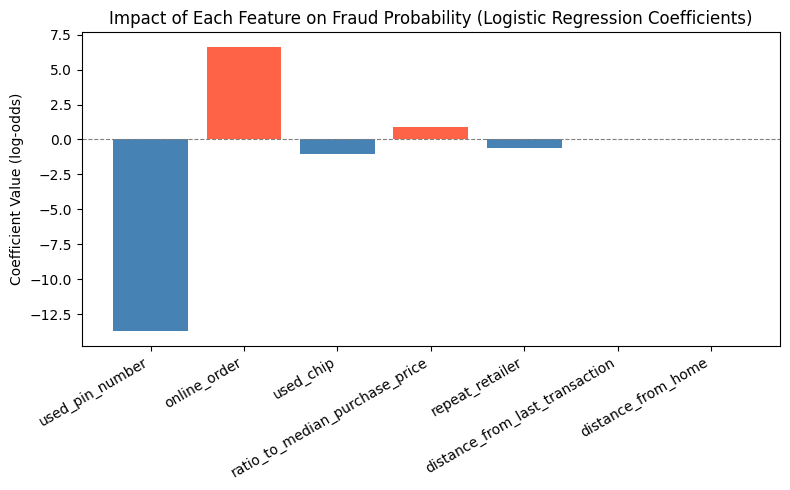

In [11]:
# Visualize feature impact (coefficients) from logistic regression, sorted by absolute value
import matplotlib.pyplot as plt
import numpy as np

# Extract coefficients (excluding intercept) and sort by absolute value
coef = model.params.drop('const')
coef_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)
features = coef_sorted.index
values = coef_sorted.values

plt.figure(figsize=(8, 5))
bars = plt.bar(features, values, color=np.where(values > 0, 'tomato', 'steelblue'))
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
plt.title('Impact of Each Feature on Fraud Probability (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value (log-odds)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

**Key Findings:**

- **Used Pin Number**: Strong negative effect ($\beta = -13.74$). PIN usage is highly protective against fraud.
- **Online Order**: Large positive effect ($\beta = 6.65$). Online transactions are much more likely to be fraudulent.
- **Used Chip**: Negative effect ($\beta = -1.05$). Chip usage reduces fraud risk.
- **Ratio to Median Purchase Price**: Strongest positive effect ($\beta = 0.86$). Higher purchase ratios greatly increase fraud risk.
- **Repeat Retailer**: Negative effect ($\beta = -0.62$). Transactions at familiar retailers are less likely to be fraudulent.
- **Distance From Home / Last Transaction**: Low positive coefficients ($\beta = 0.015$, $0.025$), relatively insignificant

The model fits well ($PseudoR^2 = 0.54$), but some features may perfectly predict fraud in a subset of cases (quasi-separation warning).

### Visualising the Logistic Regression S-Curve

To visualise the logistic regression, we plot the predicted probability of fraud against the continuous variable with the strongest effect: **ratio_to_median_purchase_price**.

All other features are held at their mean values.

This demonstrates how the probability of fraud changes as the purchase price ratio increases, according to the fitted model.

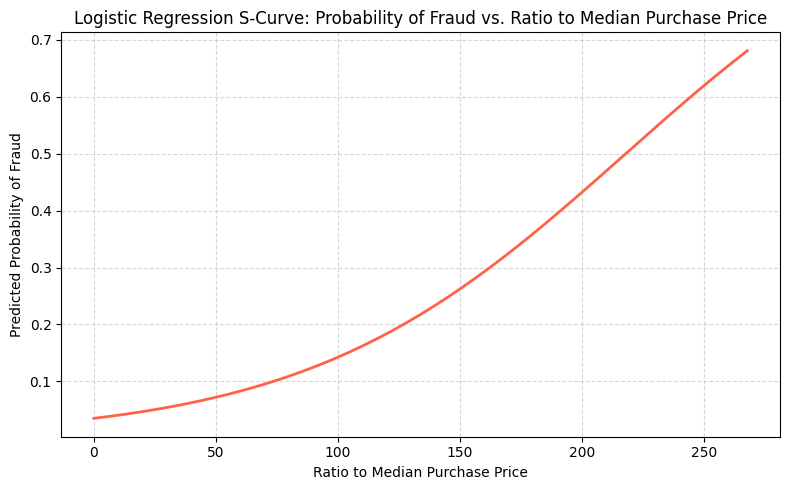

In [ ]:
# Plot the logistic regression S-curve for ratio_to_median_purchase_price
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of values for the feature
ratio_range = np.linspace(df['ratio_to_median_purchase_price'].min(), df['ratio_to_median_purchase_price'].max(), 200)

# Create a dataframe holding mean values for all features except the one of interest
mean_vals = X.drop(columns=['ratio_to_median_purchase_price']).mean()
X_curve = pd.DataFrame({
    'const': 1,
    'ratio_to_median_purchase_price': ratio_range,
    **{col: mean_vals[col] for col in mean_vals.index}
})

# Predict probabilities using the fitted model
prob_curve = model.predict(X_curve)

# Plot the S-curve
plt.figure(figsize=(8, 5))
plt.plot(ratio_range, prob_curve, color='tomato', linewidth=2)
plt.title('Logistic Regression: Probability of Fraud vs. Ratio to Median Purchase Price')
plt.xlabel('Ratio to Median Purchase Price')
plt.ylabel('Predicted Probability of Fraud')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Conclusion

**Summary of Findings:**

1. **Does physical location actually matter?**
   - Actual physical location's effect is modest compared to other features. However, online purchases (non-physical) showed a strong positive association with fraud risk.

2. **Do security measures work?**
   - Using a PIN and chip technology strongly reduces fraud risk. These are the most significant features in the model.

3. **Is the purchase amount definitive?**
   - Although not definitive, transactions' ratio to the median purchase price shows a notable positive association with fraud risk.

Overall, the analysis highlights the importance of security features and transaction context in predicting fraud, providing actionable insights for risk management.